# Safe Absorbing States

In [1]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *

%matplotlib inline
from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time
import os

2024-01-06 16:23:40.541992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_gws = []
policies = []

# policy_model = build_policy_model(channeled(csrl, enc, agent=False)[0,0,0,0].sum(0).shape, Policy[0,:,:,:].shape)
policy_model = build_policy_model((3,3), (4, 3, 3, 8))
# policy_model.summary()

2024-01-06 16:23:44.547823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 16:23:44.549398: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Number of Omega-automaton states (including the trap state): 4


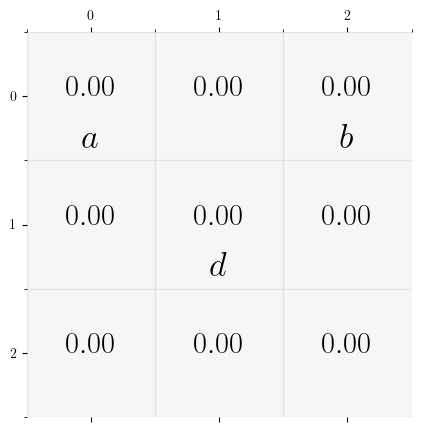

In [3]:
# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (3,3)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E'],
])

# Labels of the states
label = np.array([
[('a',),(),('b',)],
[(),('d',),    ()],
[(),    (),    ()],
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)

In [4]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)
predicates

{'a': [0], 'b': [2], 'd': [4]}

In [5]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
# model.summary()

In [6]:
LTL_coef = 10
NN_value_active = False
search_depth = 100
MCTS_samples = 100
training = True
epochs = 15
C = 1
tow = 0.1
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []
best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

num_training_epochs =  10
# os.remove("outputs/Log_run.txt")
for i in T:
    idx += 1
    train_wins = 0
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True, 
                best_val_len = best_val_len)
        
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
    print("Train wins:",train_wins,"/", num_training_epochs)

# u, d, r, l

0 ) MCTS conf: -0.36 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [5, 5, 8, 7, 6, 3, 0, 0, 0, 3, 4]
1 ) MCTS conf: -0.39 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]
2 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [6, 3, 0, 0]
3 ) MCTS conf: 0.58 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]
4 ) MCTS conf: 0.96 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [1, 0, 0]
5 ) MCTS conf: 0.97 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]


KeyboardInterrupt: 

In [16]:
Policy = np.zeros(csrl.shape)
for i in csrl.states():
    x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))
    Policy[i] = np.nan_to_num(x)

input_gws.append(channeled(csrl, enc, agent=False)[0,0,0,0].sum(0))
policies.append(Policy[0,:,:,:])

/tmp/ipykernel_110381/263196528.py:3: RuntimeWarning: invalid value encountered in divide
  x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))


In [18]:
x = np.array(input_gws)
y = np.array(policies)

In [94]:
policy_model.fit(x, y, epochs = 1000)

Epoch 1/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3965 - accuracy: 0.7639
Epoch 2/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.3962 - accuracy: 0.7639
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.3960 - accuracy: 0.7639
Epoch 4/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3958 - accuracy: 0.7685
Epoch 5/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3956 - accuracy: 0.7685
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.3954 - accuracy: 0.7731
Epoch 7/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3952 - accuracy: 0.7778
Epoch 8/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.3950 - accuracy: 0.7778
Epoch 9/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3948 - accuracy: 0.7731
Epoch 10/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.3946 - accuracy: 0.7731
Epoch 11/

KeyboardInterrupt: 

In [136]:
pred_policy = policy_model(channeled(csrl, enc, agent=False)[0,0,0,0].sum(0).reshape(1,3,3))
# pred_policy = policy_model(input_gws[4].reshape(1,3,3))

pred_policy = np.argmax(pred_policy[0,0], 2)
pred_policy = np.where(pred_policy == 0, '^', pred_policy)
pred_policy = np.where(pred_policy == '1', 'v', pred_policy)
pred_policy = np.where(pred_policy == '2', '>', pred_policy)
pred_policy = np.where(pred_policy == '3', '<', pred_policy)

In [137]:
channeled(csrl, enc, agent=False)[0,0,0,0].sum(0).reshape(1,3,3)

array([[[2., 0., 3.],
        [0., 4., 0.],
        [0., 0., 0.]]])

In [138]:
pred_policy

array([['5', '>', '6'],
       ['>', '^', '^'],
       ['^', '^', '<']], dtype='<U21')

In [126]:
input_gws

[array([[2., 0., 3.],
        [0., 0., 0.],
        [0., 4., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 0.],
        [4., 0., 0.]]),
 array([[2., 0., 3.],
        [4., 0., 0.],
        [0., 0., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 4.],
        [0., 0., 0.]]),
 array([[2., 4., 3.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 0.],
        [0., 0., 4.]])]

In [9]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 100
MCTS_samples = 100

num_training_epochs =  10
num_test_epochs = 10
training = True
epochs = 10
C = 1
tow = 0.1
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

# os.remove("Log_run.txt")
for i in T:
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True, 
                best_val_len = best_val_len)
        # print("!", best_val_len[(0,0,0,0)])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True, reachability=True, best_val_len = best_val_len)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

? 0.6
0 ) MCTS conf: 0.17 , det: 1.0 | ? 1
LTL [+++]  LDBA [ 0.01 ] path: [3, 0, 0]
? 0.05260303
? 1
1 ) MCTS conf: 0.96 , det: 1.0 | ? 1
LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
? 0.06288229
? 0.9939205570480697
? 1
2 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [6, 3, 0, 0]
? 0.0014226277
? 1
3 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 5, 2, 2]
? 0.34072602
? 0.37543768
? 0.3911557
? 1
4 ) MCTS conf: 0.22 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
5 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
6 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
7 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
8 ) MCTS conf: 0.19 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [3, 0, 0]
9 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
Train wins: 10 / 10
? 0.31173742
? 0.32700434
? 1
None ) MCTS conf: 0.8 , det: 0.7 | LTL [+++]  LDBA [ 0.01 ]

/tmp/ipykernel_20664/263196528.py:3: RuntimeWarning: invalid value encountered in divide
  x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))


In [10]:
# best_val_len ????